In [1]:
import pickle
import os

import numpy                 as np
import pandas                as pd
import matplotlib.pyplot     as plt
import seaborn               as sns

from   einops                import rearrange
from   sklearn.decomposition import PCA

from   utils                 import load_data, process_data, run_svd
from   plotting              import plot_principal_movement, plot_all_movements, plot_state_space
from   tqdm.notebook         import tqdm


# SET PARAMETERS
FREQ = 25
NEW_FREQ = 10 # desired frequency 

# signal filter
FILTER = True

# number of videos to calculate components
N_SELECT = 100

# number of principal movements / movement modes
N_MODES = 15

# data directories
DATA_DIR = 'trajectory_data/'

# output directories
FIGURE_DIR = 'figures/'
OUTPUT_DIR = 'outputs/'
os.makedirs(FIGURE_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Principal Component Analysis of keypoint trajectories
Following [Federolf, J Biomechanics, 2016](https://www.sciencedirect.com/science/article/pii/S0021929015007381), PCA applied to motion data can be interpreted as a set of Principal Movements (PM) that vary in contribution to the overall subject pose at any given time. Strength, variance or covariance of patterns over time could vary in clinical vs healthy populations. 

We use the same data as in the GMA prediction study. One video is removed as it is high resolution compared to the others, and one is removed as there is no age at video recorded. 

To remove low-frequency drift and high-frequency jitter, we apply a bandpass filter (0.01 -> 5Hz). After removing drift, timesteps where x or y position was >3 standard deviations (based on Median Absolute Deviation) from the median position across the whole cohort were identified as outliers. To reduce computation timeseries are downsampled to 10Hz (ignoring outlier points).

In [2]:
# load data
data, info = load_data(DATA_DIR)

# for recon later
median_position = np.median(data, axis=(0,1))

processed_data, outliers = process_data(data, do_filter=FILTER, new_frequency = NEW_FREQ, frequency=FREQ)
nsub, npoints, nfeatures = np.shape(processed_data)

removing 1 outlier video
removing 1 videos with no age at video


### Plot of timeseries filtering

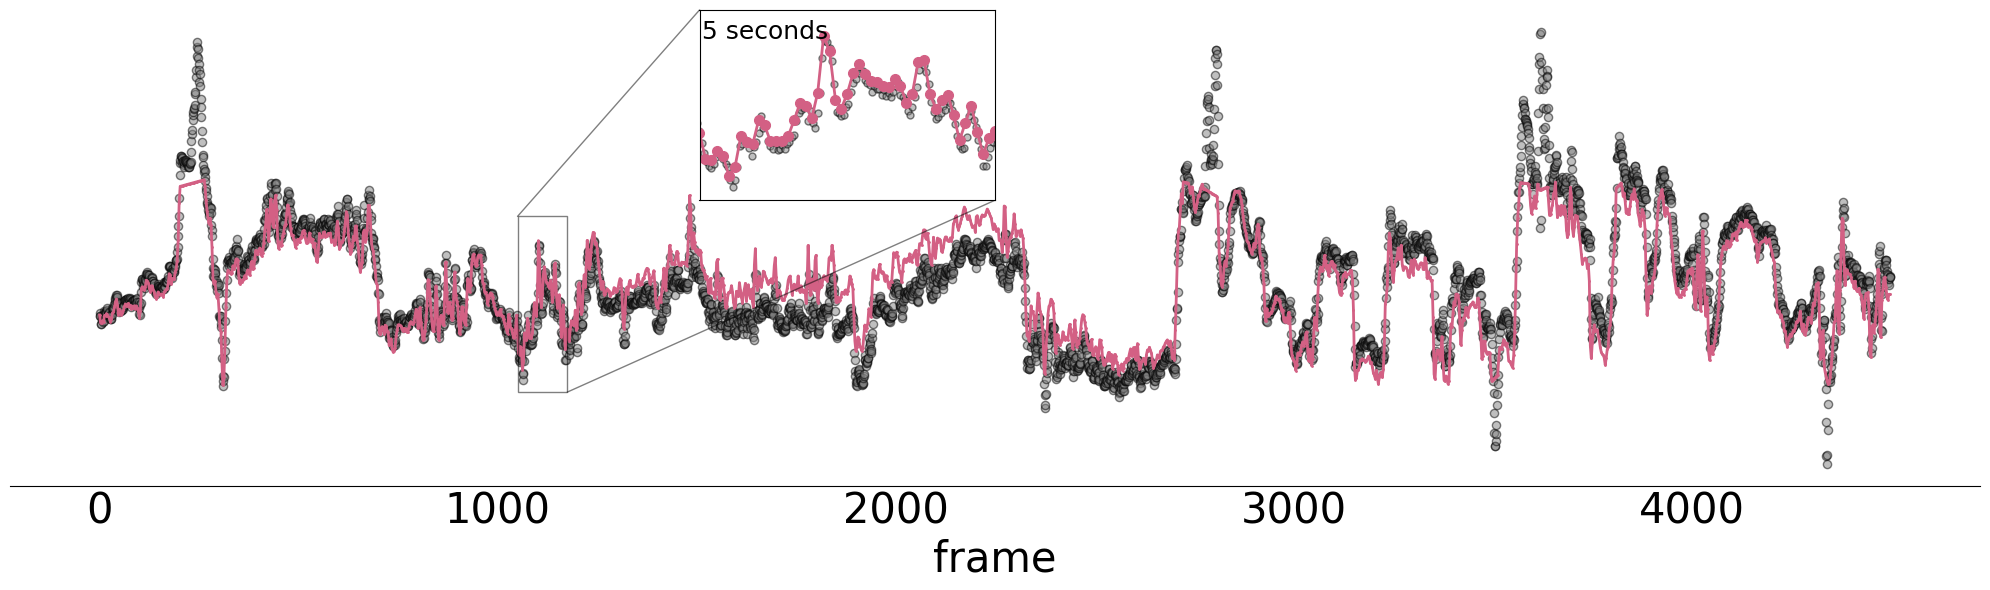

In [3]:
keypoint = 9
fig, ax = plt.subplots(1,1, figsize=(20,6))
xdata = np.arange(4500)
ydata = (data[0,:,keypoint] - np.mean(data[0,:,keypoint])) # subect 0, keypoint 
xfdata = np.arange(4500 * (NEW_FREQ/FREQ)) * (FREQ/NEW_FREQ)
fdata = processed_data[0,:,keypoint] - np.mean(processed_data[0,:,keypoint])

ax.scatter(xdata, ydata, s=35, edgecolor='black', facecolor='grey', alpha=0.5)
ax.plot(xfdata,fdata, '-o', lw=2, c='#d36084', markersize=1)
ax.set_yticklabels([])
ax.tick_params(length=0, labelsize=30)
ax.set_xlabel('frame', fontsize=30)

# inset axes....
axins = ax.inset_axes([0.35, 0.6, .15, .4])
axins.scatter(xdata, ydata, s=25, edgecolor='black', facecolor='grey', alpha=0.5)
axins.plot(xfdata, fdata, '-o', lw=2, c='#d36084', markersize=7)

axins.set_xlim(1050, 1175)
axins.set_ylim(-5, 3)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.tick_params(length=0)
axins.text(1051,1.8,'5 seconds', fontsize=18)
ax.indicate_inset_zoom(axins, edgecolor="black")

sns.despine(ax=ax, left=True)

plt.tight_layout()
plt.savefig('{:}/signal_filter.png'.format(FIGURE_DIR), transparent=False, dpi=350)

Initially, just taking a random subset to build the model. This could be done in a CV loop, or using all subjects, or all healthy subjects etc. We should demonstrate that the PMs are stable given the training set.

In [4]:
# take random subset
print('')
print('select {:} at random'.format(N_SELECT))
rand_idx = np.arange(nsub)
np.random.seed(1001) # fix for replicating
np.random.shuffle(rand_idx)
model_data = processed_data[rand_idx[:N_SELECT],:,:]

#save record of subects in subset
info.to_csv('{:}all_subject_info.csv'.format(OUTPUT_DIR), index=None)
info.iloc[rand_idx[:N_SELECT]].to_csv('{:}random_subset_info.csv'.format(OUTPUT_DIR), index=None)


select 100 at random


Each subjects timeseries are demeaned to remove body position and normalised to unit standard deviation to equalise the contribution of each to the PCA. So relatively small movements in a head keypoint, with relatively little freedom to move, are treated equally to larger movements in e.g.: foot points where there is more freedom to move. We can change this if neccesary.

In [5]:
# demean and standardise the timeseries of each coordinate within subject
subject_means = [] # save for reconstruction later
subject_norms = [] # save for reconstruction later
subject_data_normed = []

# masked data
for i in tqdm(np.arange(N_SELECT)):
    # demean
    subject_means.append(np.mean(model_data[i], axis=0))
    demeaned_data = np.subtract(model_data[i], subject_means[i])
    
    # norm
    subject_norms.append(np.std(demeaned_data, axis=0))
    subject_data_normed.append(np.divide(demeaned_data, subject_norms[i]))

# concatenate timeseries across subjects
np.save('{:}subject_data_means.npy'.format(OUTPUT_DIR), subject_means)
np.save('{:}subject_data_norms.npy'.format(OUTPUT_DIR), subject_norms)

subject_data_normed = np.concatenate(subject_data_normed, axis=0).T
print('concatenated dimensions: {:} x {:}'.format(*subject_data_normed.shape))

  0%|          | 0/100 [00:00<?, ?it/s]

concatenated dimensions: 36 x 180000


### PCA decomposition
Perform PCA on concatenated movement data. See [Federolf](https://www.sciencedirect.com/science/article/pii/S0021929015007381) again  

For a $t$ timepoint $\times$ $n$ keypoint matrix, $M$, eigendecomposition of the $t \times t$ covariance matrix, $M^TM$ results in eigenvectors $v_k$ with associated eigenvalues $ev_k$. Each subjects normalised timeseries can be projected onto $v_k$ to give $\epsilon^{subj}_k$, component weights over time that "...quantify a position in posture space (i.e. how much the posture at time $t$ deviates from the mean posture in direction of $v_k$)..."

As $pxp$ is a 180,000 x 180,000 matrix (!), I've used SVD:

$$ 
M = USV^T
$$

where $V = eig(M^TM)$ and $U=eig(MM^T)$ such that columns of $V$ represent $v_k$ and columns of $US$ represent $\epsilon^{subj}_k$. The eigenvalues (variance explained by each movement in the full dataset) are given by $(S^2)/(t-1)$. 

In [6]:
subject_timeseries, principal_movements, singular_values, explained_variance_ratio = run_svd(subject_data_normed.T)

subject_timeseries = subject_timeseries[:, :N_MODES] * singular_values[:N_MODES][np.newaxis,:]

principal_movements = principal_movements[:N_MODES, :]
explained_variance_ratio = explained_variance_ratio[:N_MODES]
print('total explained variance: {:.3f}'.format(sum(explained_variance_ratio)))

# save PCA output to OUTPUT_DIR
np.save('{:}principal_movements_timeseries_{:}components.npy'.format(OUTPUT_DIR, N_MODES), subject_timeseries)
np.save('{:}principal_movements_{:}components.npy'.format(OUTPUT_DIR, N_MODES), principal_movements)
np.save('{:}principal_movements_explained_variance_{:}components.npy'.format(OUTPUT_DIR, N_MODES), explained_variance_ratio)
np.save('{:}principal_movements_singular_values_{:}components.npy'.format(OUTPUT_DIR, N_MODES), singular_values[:N_MODES])

total explained variance: 0.890



### Some plots
Here, we plot the PCA scree plot of the selected components. As well as some state-space plots and plots of each principal movement across the full range of weights.
    

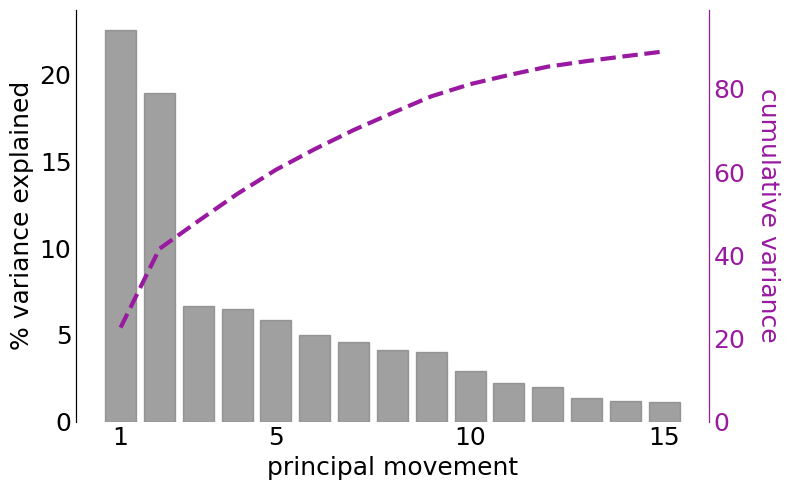

In [7]:
# variance explained by each principal movement
fig, ax = plt.subplots(1,1, figsize=(8,5))
ax1 = ax.twinx()

ax.bar(x=np.arange(N_MODES)+1, height=explained_variance_ratio * 100, edgecolor='gray', alpha=0.75, facecolor='grey', zorder=0)
ax.set_xlabel('principal movement', fontsize=18)
ax.set_ylabel('% variance explained', fontsize=18)
ax.set_xticks([1, 5, 10, 15, 20, 25])

ax.tick_params('both', labelsize=18, length=0)

ax1.plot(np.arange(N_MODES)+1, np.cumsum(explained_variance_ratio * 100), lw=3, color='#9919a0', linestyle='--')
ax1.set_ylim(0,99)
ax1.set_ylabel('cumulative variance', fontsize=18, rotation=270, labelpad=25, color='#9919a0')
ax1.tick_params('both', labelsize=18, length=0)
ax1.tick_params('y', labelsize=18, length=0, labelcolor='#9919a0')
ax1.spines['right'].set_color('#9919a0')

sns.despine(bottom=True, right=False)
plt.tight_layout()
plt.savefig('{:}/movements_PCA_scree.png'.format(FIGURE_DIR), transparent=False, dpi=350)
plt.show()

In [ ]:
# principal movements - one per figure
all_movements = []
for component in tqdm(np.arange(N_MODES)):
    outpath = '{:}/principal_movements/component_{:02d}'.format(FIGURE_DIR, component)
    os.makedirs(outpath, exist_ok=True)

    # calculate weights and movement pattern
    min_comp = np.percentile(subject_timeseries[:,component], 5)
    max_comp = np.percentile(subject_timeseries[:,component], 95)

    z = 1/(1 + np.exp(-np.linspace(-5,5,50))) 
    z = z * (max_comp - min_comp) + min_comp
    z = np.concatenate((z, z[::-1]))

    movement_pattern = z[:,np.newaxis].dot(principal_movements[component,:][np.newaxis,:])
    recon_movement = np.mean(subject_means, axis=0) + (np.mean(subject_norms, axis=0) * movement_pattern) 
    all_movements.append(recon_movement[:,:36] + median_position)
    # plot (just movements)
    plot_principal_movement(recon_movement[:,:36] + median_position, z, outpath)
    
# principal movements - all in one figure
outpath = '{:}/principal_movements/all_components'.format(FIGURE_DIR)
os.makedirs(outpath, exist_ok=True)
plot_all_movements(all_movements, outpath)

  0%|          | 0/15 [00:00<?, ?it/s]

### Project all subject's data into feature space

Using precalculated eigenvectors, we can now project the remaining subject's movement data into the same feature space for modelling. 

Final data saved for further analysis.

In [ ]:
# save out the random subset first

subset_data = rearrange(subject_timeseries, '(s t) f -> s f t', t=npoints)
np.save('{:}random_subset_processed_timeseries_data.npy'.format(OUTPUT_DIR), subset_data)

# apply to all subects
posture_data = []

# for each subject
for i in tqdm(np.arange(len(processed_data))):
    
    d = processed_data[i]
    # remove timeseries mean
    mn = np.mean(d, axis=0)
    d = np.subtract(d, mn)
    # norm to std=1
    sd = np.std(d, axis=0)
    d = np.divide(d, sd)
    # dot with eigenvectors
    d = np.dot(d, principal_movements.T)
    
    posture_data.append(d)

# check it worked as expected
assert np.allclose(subject_timeseries[:npoints,:], posture_data[rand_idx[0]])

# save out
np.save('{:}all_processed_timeseries_data.npy'.format(OUTPUT_DIR), posture_data)